# Лабораторная работа №4 - Восстановление функции распренделения вероятности
М80-114СВ-24

Грушецкий Г.А.

## Реализация методов восстановления плотности и тестирование методов с визуализацией на двух наборах данных


### Импорт библиотек

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

### Метод ядерного сглаживания и визуализация

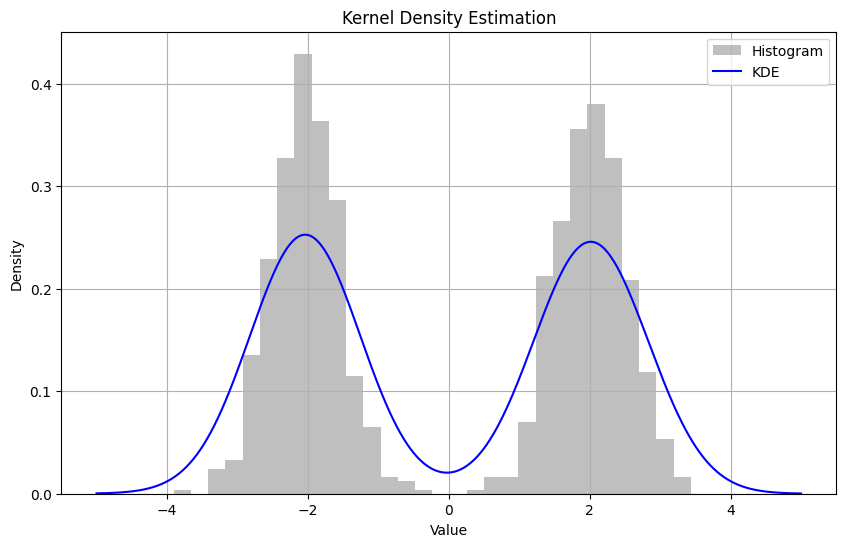

In [77]:
def kernel_density_estimation(data, bandwidth):
    kde = gaussian_kde(data, bw_method=bandwidth)
    #density = kde(x_values)
    return kde #density

# Пример использования
if __name__ == "__main__":
    # Генерация случайных данных
    np.random.seed(50)
    data = np.concatenate([np.random.normal(loc=-2, scale=0.5, size=500),
                           np.random.normal(loc=2, scale=0.5, size=500)])
    x_values = np.linspace(-5, 5, 1000)
    bandwidth = 0.3
    density = kernel_density_estimation(data, bandwidth)
    y_vals = density(x_values)
    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=30, density=True, alpha=0.5, label='Histogram', color='gray')
    plt.plot(x_values, y_vals, label='KDE', color='blue')
    plt.title('Kernel Density Estimation')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()

### Метод ЕМ алгоритма и визуализация

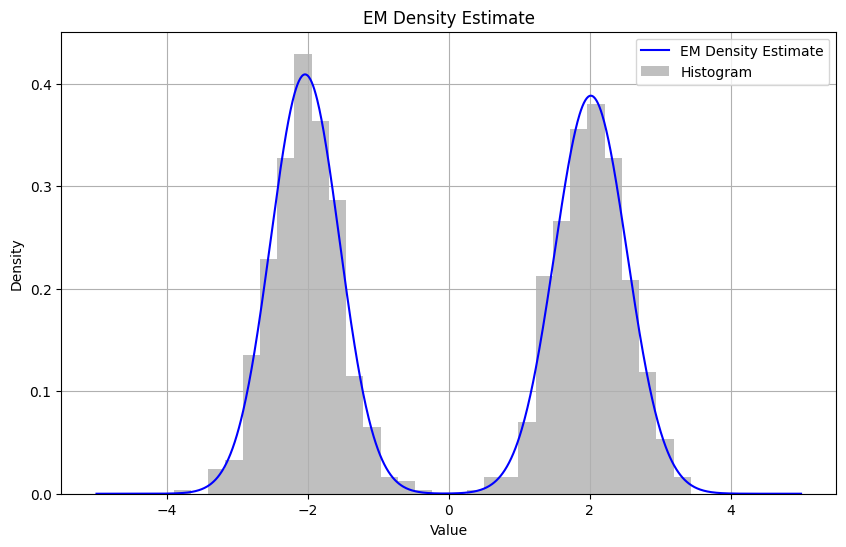

In [78]:
from scipy.stats import norm

def em_algorithm(data, num_components, num_iterations=100):
    n = len(data)
    # Инициализация параметров
    means = np.random.choice(data, num_components)  # случайные средние
    stds = np.random.rand(num_components)  # случайные стандартные отклонения
    weights = np.ones(num_components) / num_components  # веса

    for _ in range(num_iterations):
        # E-шаг: вычисление ответственности
        responsibilities = np.zeros((n, num_components))
        for k in range(num_components):
            responsibilities[:, k] = weights[k] * norm.pdf(data, means[k], stds[k])

        responsibilities /= responsibilities.sum(axis=1, keepdims=True)  # нормализация

        # M-шаг: обновление параметров
        weights = responsibilities.mean(axis=0)
        means = (responsibilities.T @ data) / responsibilities.sum(axis=0)
        stds = np.sqrt((responsibilities.T @ (data**2)) / responsibilities.sum(axis=0) - means**2)

    return means, stds, weights

def compute_density(data, means, stds, weights, x_values):
    density = np.zeros_like(x_values)
    for k in range(len(means)):
        density += weights[k] * norm.pdf(x_values, means[k], stds[k])
    return density

from sklearn.mixture import GaussianMixture
def em_density_estimation(data, n_components=2):
    data = data.reshape(-1, 1)
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(data)
    return gmm
    # Генерация случайных данных (двух гауссовских распределений)
np.random.seed(50)
data = np.concatenate([np.random.normal(loc=-2, scale=0.5, size=500),
                           np.random.normal(loc=2, scale=0.5, size=500)])

    # Количество компонент в смеси
num_components = 2

    # Запуск EM алгоритма
means, stds, weights = em_algorithm(data, num_components)

    # Определение диапазона значений x для оценки плотности
x_values = np.linspace(-5, 5, 1000)
density = compute_density(data, means, stds, weights, x_values)
plt.figure(figsize=(10, 6))
plt.plot(x_values, density, label='EM Density Estimate', color='blue')
plt.hist(data, bins=30, density=True, alpha=0.5, label='Histogram', color='gray')
plt.title('EM Density Estimate')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

## Реализация методов Метрополиса-Гастингса и Гибсона для несимметричного распределения

### Метод Метрополиса-Гастингса

In [79]:
def metropolis_hastings(target_distribution, initial_value, iterations, step_size):
    samples = [initial_value]
    current = initial_value
    for _ in range(iterations-1):
        proposed = np.random.normal(current, step_size)
        acceptance_ratio = target_distribution(proposed) / target_distribution(current) #density
        if np.random.rand() < acceptance_ratio:
            current = proposed
        samples.append(current)
    return np.array(samples)

### Метод Гиббса

In [80]:
def gibbs_meth(num_samples, conditional_distributions, initial_values):
    samples = [initial_values]
    current_state = np.array(initial_values)
    for _ in range(num_samples-1):
        for j, cur in enumerate(conditional_distributions):
            # Обновление j-го элемента состояния с использованием j-го условного распределения
            current_state[j] = cur(*current_state[:j], *current_state[j+1:])
        samples.append(current_state.copy())
    return np.array(samples)

## Визуализация применения двух методов для восстановленной функции плотности, получая изначальные точки

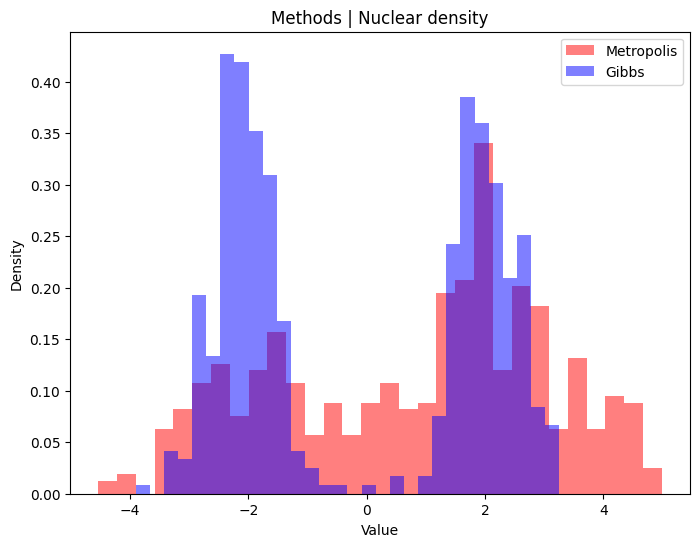

In [81]:
np.random.seed(50)
data = np.concatenate([np.random.normal(loc=-2, scale=0.5, size=500),
                           np.random.normal(loc=2, scale=0.5, size=500)])
kde = kernel_density_estimation(data, bandwidth=0.5)
n_samples = 500
density_goal = kde.evaluate
metropolis_ret = metropolis_hastings(density_goal, data.mean(), n_samples, step_size=1.0)
gibbs_ret = gibbs_meth( n_samples,  [lambda: np.random.choice(data)], [data.mean()])
plt.figure(figsize=(8, 6))
plt.hist(metropolis_ret, bins=30, density=True, alpha=0.5, label='Metropolis', color='red')
plt.hist(gibbs_ret, bins=30, density=True, alpha=0.5, label='Gibbs', color='blue')
plt.title('Methods | Nuclear density')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

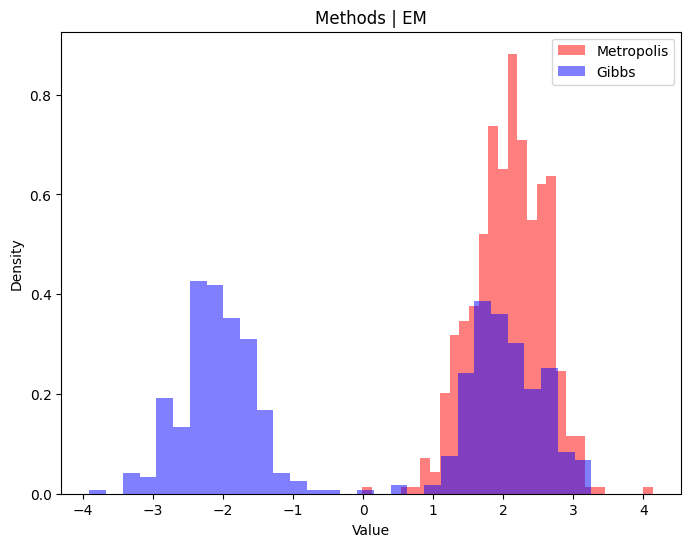

In [82]:
np.random.seed(50)
data = np.concatenate([np.random.normal(loc=-2, scale=0.5, size=500),
                           np.random.normal(loc=2, scale=0.5, size=500)])
def density_meth(x):
    return np.exp(em.score_samples(np.array([[x]])))
em = em_density_estimation(data, n_components=2)
metropolis_ret = metropolis_hastings(density_meth, data.mean(), n_samples, step_size=1.0)
gibbs_ret= gibbs_meth( n_samples, [lambda: np.random.choice(data)],  [data.mean()])
plt.figure(figsize=(8, 6))
plt.hist(metropolis_ret, bins=30, density=True, alpha=0.5, label='Metropolis', color='red')
plt.hist(gibbs_ret, bins=30, density=True, alpha=0.5, label='Gibbs', color='blue')
plt.title('Methods | EM')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

## Выводы

В данной лабораторной работе:

Реализованы метод восстановления плотности вероятности двумя способами:
        
1. EM-алгоритм
2. Ядерное сглаживание

Данные методы применены на наборе случайных точек

Реализованы методы Метрополиса-Гастингса и Гибсона для несимметричного распределения. Оба метода применены на основе той функции плотности, которая была восстановлена в прошлом пункте, тем самым получая изначальные точки.